# Dask start

In [12]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:55845")
client

<Client: 'tcp://127.0.0.1:55845' processes=4 threads=8, memory=16.00 GiB>

# Import

In [13]:
#import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage

# Load data

Choose cases

In [14]:
data=[dict(),dict()]

In [15]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GS winter'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GS summer'})

## eNATL60

In [16]:
# from validate_catalog import all_params
# params_dict, cat = all_params()

In [17]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,12),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)

In [18]:
nb_of_time_chunks = 7

In [19]:
%%time
for i in range(len(data)) :
    #current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask().\
    current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    current_set = current_set.isel(data_slice)
    current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 88.9 ms, sys: 80.4 ms, total: 169 ms
Wall time: 1.73 s


## eORCA025

In [20]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_dataset("/Users/ana/data/eNATL60_extractions/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon')

## Compare

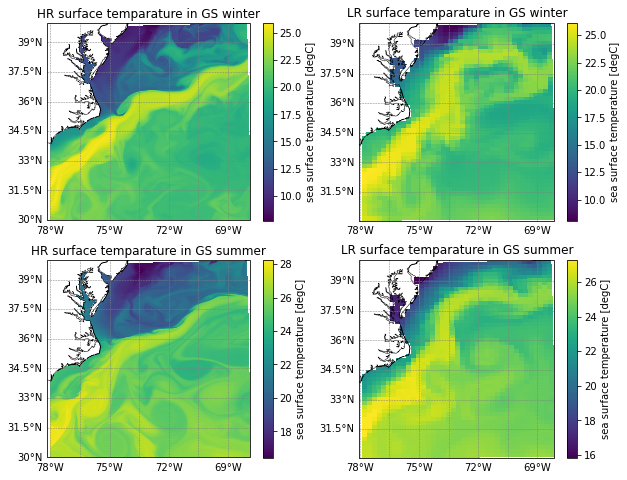

In [36]:
fig, axis = plt.subplots(ncols=2, nrows=len(data), figsize=(5*len(data),8), subplot_kw={'projection': ccrs.PlateCarree()})
for row in range(len(data)) :
    for col, dataSetKey in enumerate(['HR', 'LR']) :
        data[row][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' surface temparature in ' + data[row]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

In [37]:
# fig, axis = plt.subplots(ncols=2, nrows=len(data), figsize=(5*len(data),8), subplot_kw={'projection': ccrs.PlateCarree()})
# for row in range(len(data)) :
#     for col, dataSetKey in enumerate(['HR', 'LR']) :
#         data[row][dataSetKey].isel(time_counter=-1).sosaline[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
#         axis[row,col].set(title=dataSetKey + ' surafce salinity in ' + data[row]['label'])

# for ax in axis.flatten() :
#     ax.coastlines(color='k', lw=0.5)
#     gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
#     gl.top_labels = False; gl.right_labels = False

# Density

Compute conservative temperature and density anomaly $\sigma_0$ with the use of `gsw` library:

In [62]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR', 'LR'] :
        data[i][dataKey]['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized').compute()
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['CT'], dask='parallelized').compute()

CPU times: user 433 ms, sys: 137 ms, total: 570 ms
Wall time: 712 ms


# Filter data

## Routines

In [41]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=True).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    
    # binariwe and erode the mask (to remove isolated pixels)
    threshold = 0.9
    new_wetmask = ndimage.binary_erosion(np.where((result['tmask'] > threshold), 1.0, 0.0))
    result['tmask'] = (['y','x'], new_wetmask.astype(np.float32))
    # apply new mask to data
    result = result.where(result.tmask>0)
    return result

In [42]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            n_iterations=2,
            filter_scale=filter_scale,    
             dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

## Set of filters to compare

In [63]:
coarsening_window_size = 12
filters = [dict({'filter_coef' : 0, 'coarsening_window_size' : coarsening_window_size}),
          dict({'filter_coef' : 12, 'coarsening_window_size' : coarsening_window_size}),
          dict({'filter_coef' : 24, 'coarsening_window_size' : coarsening_window_size}),
          dict({'filter_coef' : 36, 'coarsening_window_size' : coarsening_window_size})]

In [64]:
%%time
for i in range(len(data)) : 
    data[i]['HR_Filtered'] = [] 
    for ifilter, curr_filter in enumerate(filters) :
        data[i]['HR_Filtered'].append(apply_filter_downsample(data[i]['HR'], curr_filter['filter_coef'], curr_filter['coarsening_window_size']).compute().\
                                                               chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}))

CPU times: user 3min 28s, sys: 1min 44s, total: 5min 12s
Wall time: 5min 11s


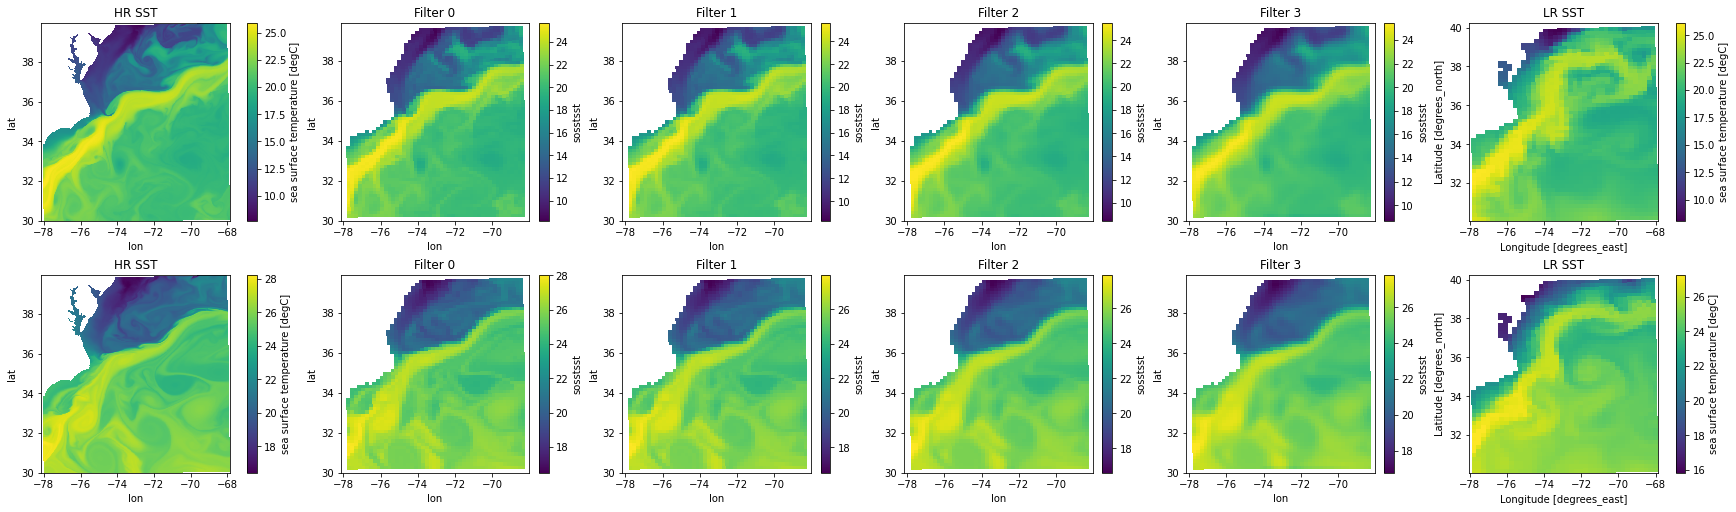

In [109]:
fig, axis = plt.subplots(ncols=6, nrows=2, figsize=(24,7), constrained_layout=True)
quantity='sosstsst'
for row in range(len(data)) :
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0])
    axis[row,0].set(title='HR SST')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title='Filter ' +str(ifilter))
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1])
    axis[row,-1].set(title='LR SST')    

# Density correction

Low-resolution density

In [66]:
%%time
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        ds = data[i]['HR_Filtered'][ifilter]
        ds['CT'] = xr.apply_ufunc(gsw.conversions.CT_from_pt, ds['sosaline'], ds['sosstsst'], dask='parallelized').compute()
        ds['sigma0_model'] = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['CT'], dask='parallelized').compute()
        ds['sigma0_delta'] = ds['sigma0_true'] - ds['sigma0_model']

CPU times: user 172 ms, sys: 28.9 ms, total: 201 ms
Wall time: 756 ms


In [78]:
x_slice = slice(0,-1)
y_slice = slice(2,-2)

bord_cut = dict(y=y_slice,x=x_slice) # to cut borders 

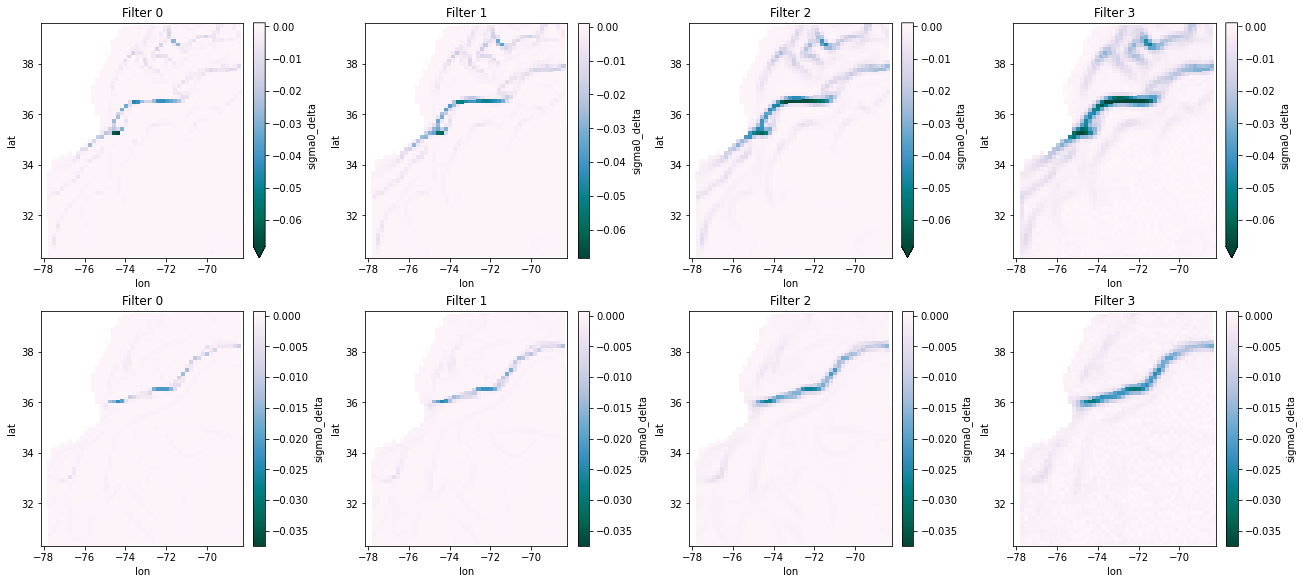

In [80]:
fig, axis = plt.subplots(ncols=4, nrows=2, figsize=(18,8), constrained_layout=True)
quantity='sigma0_delta'
for row in range(len(data)) :
    norm = colors.Normalize(vmin=data[row]['HR_Filtered'][-1].isel(time_counter=0).sigma0_delta.min().values, \
                            vmax=data[row]['HR_Filtered'][-1].isel(time_counter=0).sigma0_delta.max().values)
    for ifilter in range(len(filters)) :
        col = ifilter
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity][bord_cut].plot(x='lon', y='lat', ax=axis[row,col], norm=norm, cmap='PuBuGn_r')
        axis[row,col].set(title='Filter ' +str(ifilter))  

# Derivatives

In [87]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [88]:
def diffs_x(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffs_y(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [143]:
%%time
for i in range(len(data)) :
    for ds in [data[i]['HR']] + [data[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [data[i]['LR']] :
        ds["alpha"], ds["beta"] = eos_module.alpha_beta(ds["sosaline"], ds["CT"])
        ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['CT'])
        ds['gradx_temp'] = gradx(ds['CT'], ds['e1t'])
        ds['grady_temp'] = grady(ds['CT'], ds['e2t'])
        ds['gradx_sal'] = gradx(ds['sosaline'], ds['e1t'])
        ds['grady_sal'] = grady(ds['sosaline'], ds['e2t'])
        ds['grad_temp_sqr'] = (ds['gradx_temp']**2 + ds['grady_temp']**2).compute()
        ds['grad_sal_sqr'] = (ds['gradx_sal']**2 + ds['grady_sal']**2).compute()
        ds['grad_temp'] = np.sqrt(ds['grad_temp_sqr'])
        ds['grad_sal'] = np.sqrt(ds['grad_sal_sqr'])
        ds['alpha_nablaT'] = (ds['alpha']*ds['grad_temp']).compute()
        ds['beta_nablaS'] = (ds['beta']*ds['grad_sal']).compute()
        ds['spicyness'] = np.sqrt((ds['alpha']*ds['gradx_temp']+ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']+ds['beta']*ds['grady_sal'])**2)
        ds['buoyancy'] = np.sqrt((ds['alpha']*ds['gradx_temp']-ds['beta']*ds['gradx_sal'])**2+(ds['alpha']*ds['grady_temp']-ds['beta']*ds['grady_sal'])**2)
        ds['temp_second_deriv'] = (ds['rho_ct_ct']*ds['grad_temp_sqr']).compute()
        ds['mixed_second_deriv'] = (ds['rho_sa_ct']*ds['grad_temp']*ds['grad_sal']).compute()
        ds['sal_second_deriv'] = (ds['rho_sa_sa']*ds['grad_sal_sqr']).compute()
        ds['total_second_deriv'] = ds['temp_second_deriv']+2.*ds['mixed_second_deriv']+ds['sal_second_deriv']

CPU times: user 8.79 s, sys: 5.67 s, total: 14.5 s
Wall time: 18.5 s


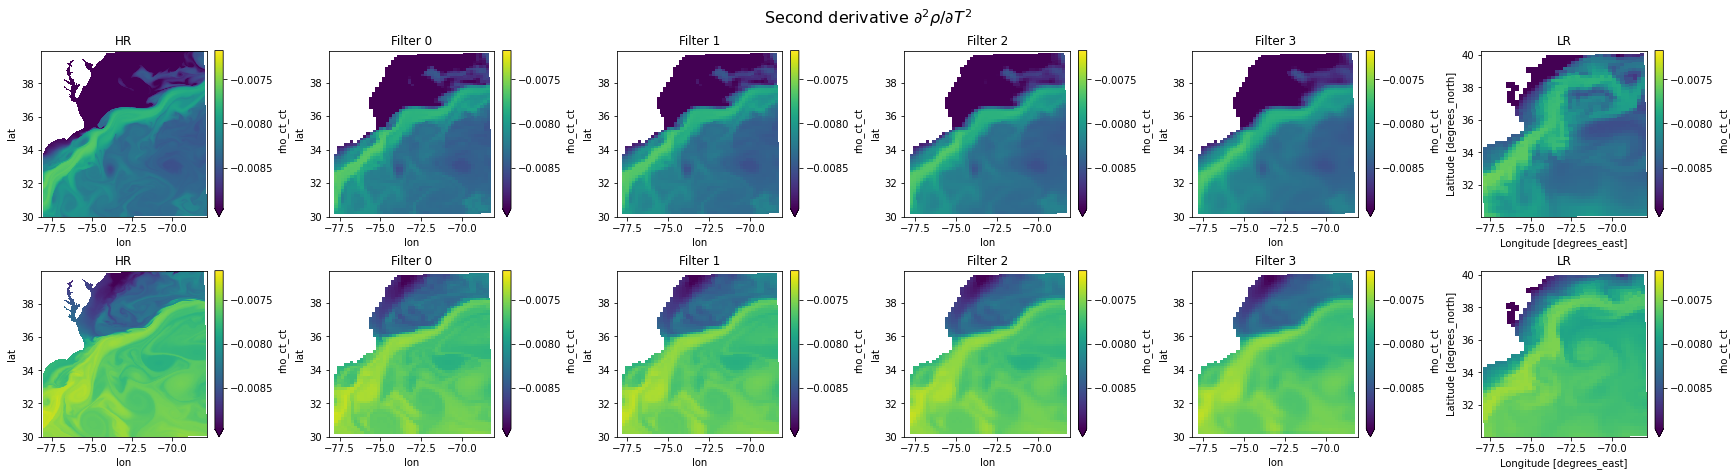

In [138]:
fig, axis = plt.subplots(ncols=6, nrows=2, figsize=(24,6.5), constrained_layout=True)
quantity='rho_ct_ct'
fig.suptitle(r'Second derivative $\partial^2 \rho/\partial T^2$', size=16)
for row in range(len(data)) :
    norm = colors.Normalize(vmin=data[region]['HR_Filtered'][0].isel(time_counter=0).rho_ct_ct.min().values, \
                            vmax=data[region]['HR_Filtered'][0].isel(time_counter=0).rho_ct_ct.max().values)
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0], norm=norm)
    axis[row,0].set(title='HR')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col], norm=norm)
        axis[row,col].set(title='Filter ' +str(ifilter))
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1], norm=norm)
    axis[row,-1].set(title='LR')    

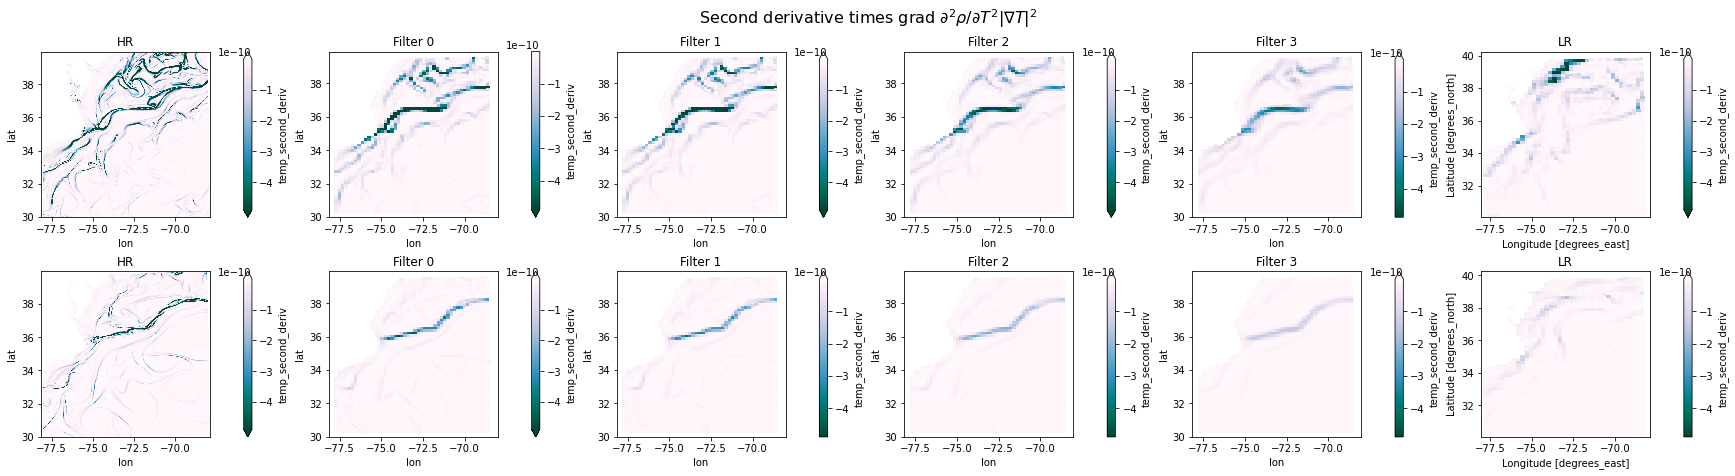

In [135]:
fig, axis = plt.subplots(ncols=6, nrows=2, figsize=(24,6.5), constrained_layout=True)
quantity='temp_second_deriv'
fig.suptitle(r'Second derivative times grad $\partial^2 \rho/\partial T^2 |\nabla T|^2$', size=16)
for row in range(len(data)) :
    norm = colors.Normalize(vmin=data[region]['HR_Filtered'][0].isel(time_counter=0).temp_second_deriv.min().values, \
                            vmax=data[region]['HR_Filtered'][0].isel(time_counter=0).temp_second_deriv.max().values)
    data[row]['HR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,0], norm=norm, cmap='PuBuGn_r')
    axis[row,0].set(title='HR')
    for ifilter in range(len(filters)) :
        col = ifilter+1
        data[row]['HR_Filtered'][ifilter].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,col], norm=norm, cmap='PuBuGn_r')
        axis[row,col].set(title='Filter ' +str(ifilter))
    data[row]['LR'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[row,-1], norm=norm, cmap='PuBuGn_r')
    axis[row,-1].set(title='LR')    

## Spatial covariance between derivatives and density correction

In [130]:
%%time 
for i in range(len(data)) :
    for ifilter in range(len(filters)) :
        ds = data[i]['HR_Filtered'][ifilter]
        for quantity in ['grad_temp', 'grad_sal', 'alpha_nablaT', 'beta_nablaS', 'spicyness', 'buoyancy', 'temp_second_deriv', 'mixed_second_deriv', 'sal_second_deriv','total_second_deriv'] :    
            ds[quantity+'_dens_covar'] = xr.corr(ds[quantity], ds['sigma0_delta'], dim=['x', 'y']).compute()

CPU times: user 2.43 s, sys: 105 ms, total: 2.54 s
Wall time: 9.63 s


In [144]:
quantity_labels=[r'$|\nabla T|$', r'$|\nabla S|$',\
                 r'$\alpha |\nabla T|$', r'$\beta |\nabla S|$', r'$|\nabla s|=|\alpha \vec{\nabla} T+ \beta \vec{\nabla} S|$', r'$|\nabla b|=|\alpha \vec{\nabla} T-\beta \vec{\nabla} S|$', \
                 r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2$', r'$\frac{\partial^2 \rho}{\partial T \partial S} |\nabla T|~|\nabla S|$', \
                 r'$\frac{\partial^2 \rho}{\partial S^2} |\nabla S|^2$',\
                r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2 + \frac{\partial^2 \rho}{\partial T \partial S} |\nabla T|~|\nabla S| + \frac{\partial^2 \rho}{\partial S^2} |\nabla S|^2$']

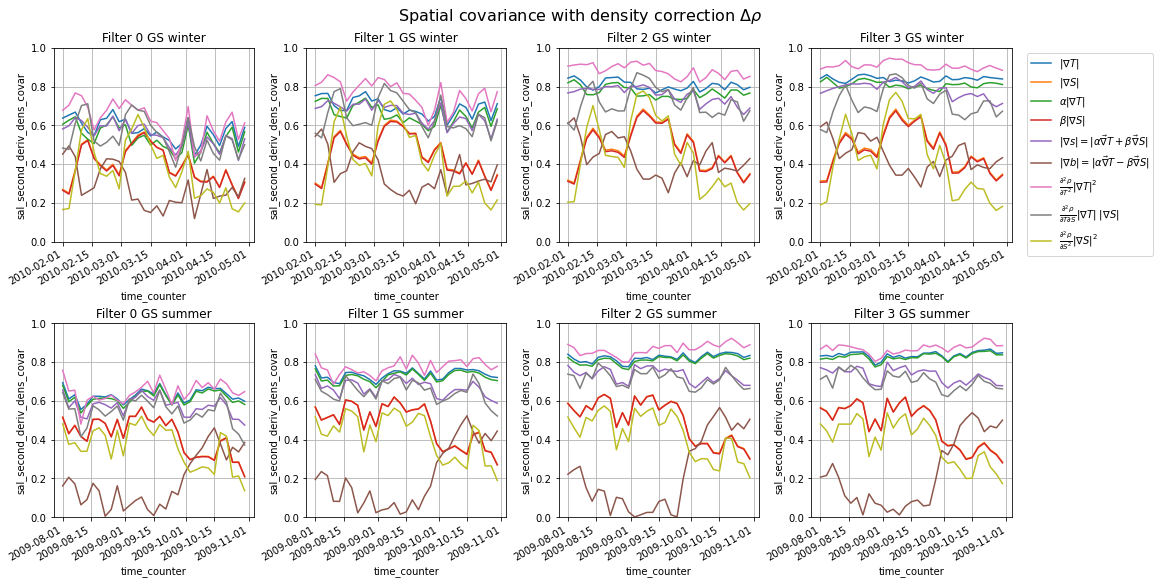

In [145]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(16,8), constrained_layout=True)
fig.suptitle(r'Spatial covariance with density correction $\Delta \rho$', size=16)
for row in range(len(data)) :
    for col in range(len(filters)) :
        ds = data[row]['HR_Filtered'][col]
        for i,quantity in enumerate(['grad_temp', 'grad_sal','alpha_nablaT', 'beta_nablaS', 'spicyness', 'buoyancy', 'temp_second_deriv', 'mixed_second_deriv', 'sal_second_deriv']) :
            abs(ds[quantity+'_dens_covar']).plot(ax=ax[row,col], label=quantity_labels[i])
            ax[row,col].set(title='Filter '+str(col)+' '+data[row]['label'])
        ax[row,col].set(ylim=[0,1]); ax[row,col].grid(True)
ax[0,-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Histograms

In [201]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(abs(dataSet[var1]).min(), abs(dataSet[var1]).max(), nb_of_bins)
        bins2 = np.linspace(abs(dataSet[var2]).min(), abs(dataSet[var2]).max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(abs(dataSet[var1].fillna(0)), abs(dataSet[var2].fillna(0)), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [202]:
min_hist = 1e-5
max_hist = 0.5
log_norm=colors.LogNorm(vmin=min_hist, vmax=max_hist)

# plotting routine
def margin_hist(data, cmap, x_bins, y_bins, ax_histx, ax_histy, ax_big):
    hist_joint = ax_big.pcolormesh(data[x_bins],data[y_bins], data.T, norm=log_norm, cmap=cmap, shading='auto', alpha=0.95)
    
    margin_hist_x = data.sum(dim=y_bins)
    ax_histx.plot(data[x_bins],margin_hist_x)
    ax_histx.set(yscale='log', ylim=[min_hist, max_hist])
    ax_histx.tick_params(labelleft=False, labelbottom=False)    
    
    margin_hist_y = data.sum(dim=x_bins)
    ax_histy.plot(margin_hist_y,data[y_bins])
    ax_histy.set(xscale='log', xlim=[min_hist, max_hist])
    ax_histy.tick_params(labelleft=False, labelbottom=False)     
    
    return hist_joint

In [203]:
nb_of_bins = 150

In [204]:
# initialize data structure
hists=[dict(),dict()]
for i in range(len(data)) :
    hists[i]['HR_Filtered'] = [dict({'label' : 'Filter '+str(i)}) for i in range(len(filters))] 
    hists[i]['HR'] = dict({'label' : 'HR'})
    hists[i]['LR'] = dict({'label' : 'LR'})

## Histograms of squares of gradients

In [210]:
%%time
name_hist = 'hist_grads_sqr'
x = 'sal_second_deriv'
y = 'temp_second_deriv'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for dataSetKey in ['HR','HR_Filtered','LR'] :
        if (dataSetKey=='HR_Filtered') :
            for ifilter in range(len(filters)) :
                hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                                   x, y, nb_of_bins, bins=bins).compute()
        else :
            hists[i][dataSetKey][name_hist] = compute_2D_histogram(data[i][dataSetKey].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins, bins=bins).compute()

CPU times: user 2.78 s, sys: 1.23 s, total: 4.01 s
Wall time: 7.33 s


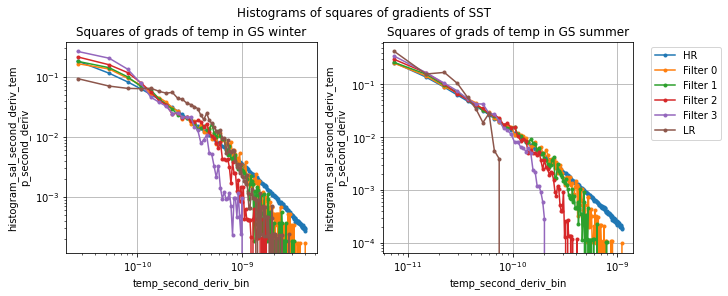

In [211]:
fig, ax = plt.subplots(ncols=len(data), nrows=1, figsize=(len(data)*5,4), constrained_layout=True)
fig.suptitle('Histograms of squares of gradients of SST')
name_hist = 'hist_grads_sqr'
for i in range(len(data)) :
    for ds_hist in [hists[i]['HR']] + [hists[i]['HR_Filtered'][ifilter] for ifilter in range(len(filters))] + [hists[i]['LR']] :
        ds_hist[name_hist].sum(dim='sal_second_deriv_bin').plot(ax=ax[i], label=ds_hist['label'], ls='-', marker='.')
    ax[i].set(title='Squares of grads of temp in ' + data[i]['label'], yscale='log', xscale='log'); ax[i].grid(True)
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Joint histograms of grads and density correction

In [213]:
%%time
name_hist = 'hist_deriv2_temp_dens'
x = 'temp_second_deriv'
y = 'sigma0_delta'
for i in range(len(data)) :
    # reference histogram
    ref_case = 0
    hists[i]['HR_Filtered'][ref_case][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ref_case].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), x, y, nb_of_bins).compute()
    ref_hist = hists[i]['HR_Filtered'][ref_case][name_hist]
    bins = [ref_hist[x+'_bin'].values, ref_hist[y+'_bin'].values]
    for ifilter in range(len(filters)) :
        hists[i]['HR_Filtered'][ifilter][name_hist] = compute_2D_histogram(data[i]['HR_Filtered'][ifilter].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                                   x, y, nb_of_bins, bins=bins).compute()
    

CPU times: user 337 ms, sys: 65.8 ms, total: 403 ms
Wall time: 1.37 s


In [220]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

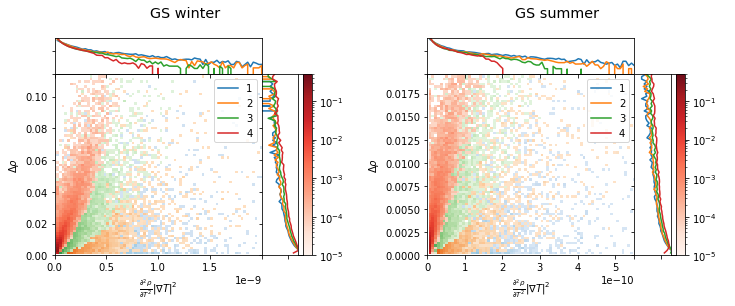

In [226]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = fig.subfigures(1, 2, wspace=0.07)
for a in axs:
    for spine in ['top', 'right', 'bottom', 'left'] :
        a.spines[spine].set_visible(False)
    a.get_xaxis().set_ticks([]); a.get_yaxis().set_ticks([])    
gs = GridSpec(2, 3, width_ratios=[10, 2.0, 1], height_ratios=[2.0, 10], wspace=0, hspace=0)
bins = ['temp_second_deriv_bin', 'sigma0_delta_bin']
for i in range(len(data)) :
    subfigs[i].suptitle(data[i]['label'], fontsize='x-large')
    big_ax = subfigs[i].add_subplot(gs[1,0]) # bottom left
    top_ax = subfigs[i].add_subplot(gs[0,0], sharex=big_ax) # top left
    right_ax = subfigs[i].add_subplot(gs[1,1], sharey=big_ax) # bottom center
    cbar_ax = subfigs[i].add_subplot(gs[1,2]) # bottom right
    cbar_ax.set(xticks=[], yticks=[])
    for ifilter in range(len(filters)) :
        hist_joint = margin_hist(hists[i]['HR_Filtered'][ifilter]['hist_deriv2_temp_dens'], cmaps_list[ifilter], bins[0], bins[1], top_ax, right_ax, big_ax)
    big_ax.set(xlabel=r'$\frac{\partial^2 \rho}{\partial T^2} |\nabla T|^2$', ylabel=r'$\Delta \rho$')
    big_ax.legend(handles=top_ax.lines, labels=['1', '2', '3','4'], loc='upper right')
    big_ax.set(xlim=[0,0.5*hists[i]['HR_Filtered'][ifilter]['hist_deriv2_temp_dens']['temp_second_deriv_bin'].max()],\
              ylim=[0,0.5*hists[i]['HR_Filtered'][ifilter]['hist_deriv2_temp_dens']['sigma0_delta_bin'].max()])
    subfigs[region].colorbar(hist_joint, ax=cbar_ax, anchor=(0.0, 0.0),pad=0.25,fraction=1.)

plt.show()